In [2]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import matplotlib.patches as patches
from shapely.geometry import Polygon
import pandas as pd
import re
import plotly.graph_objects as go
import os
import random

In [3]:
def read_seismic_cube(file_path):
  """
  :param file_path: Путь к файлу
  :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
  а также словарь сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
  """
  with segyio.open(file_path, 'r') as segyfile:
      x = list(segyfile.ilines)
      y = list(segyfile.xlines)
      z_0 = list(segyfile.samples)
      z = list()
      for i in range(len(z_0)):
          z.append(int(z_0[i]))
      cube = segyio.tools.cube(segyfile)
      #traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
  return x, y, z

In [4]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
ilines, xlines, samples = read_seismic_cube(file_path)

In [48]:
def extract_segy_data(file_path):
    """
  :param file_path: Путь к файлу
  :return: возвращает реальные координаты x, y
  """
    with segyio.open(file_path, 'r') as segyfile:
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        coord_x = set()
        coord_y = set()
        cube_coord = []
        for i in range(len(x)):
            for j in range(len(y)):
                index = i * len(y) + j
                trace_header = segyfile.header[index]
                cube_coord.append([trace_header[segyio.TraceField.SourceX], trace_header[segyio.TraceField.SourceY]])
                #coord_x.add(trace_header[segyio.TraceField.SourceX])
                #coord_y.add(trace_header[segyio.TraceField.SourceY])
    return cube_coord

In [49]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
real_cube = extract_segy_data(file_path)

In [43]:
# ридер для карты кровли и подошвы
def gorizont_coord(file):
    with open(file, 'r') as f:
        gorizon = []
        for line in f:
            if not line.startswith('#'):  # Пропуск строк, начинающихся с #
                x, y, z, *rest = line.split()  # Разбиение строки по столбцам
                x = int(x.split('.')[0])  # Получение целочисленного значения из первого столбца
                y = int(y.split('.')[0])  # Получение целочисленного значения из второго столбца
                #z = int(z.split('.')[0])  # Получение целочисленного значения из третьего столбца
                gorizon.append([x, y])  # Добавление данных в словарь

    return gorizon

In [44]:
Top_TWT = gorizont_coord('C:/HV/Seismic/datas/TWT_Top_U1.txt')
Bottom_TWT = gorizont_coord('C:/HV/Seismic/datas/TWT_Bottom_U1.txt')

In [9]:
# ридер для разломов
def process_files(directory):
    files = os.listdir(directory)
    result = {}

    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(directory, file), 'r') as f:
                data = []
                for line in f:
                    fields = line.split()
                    if len(fields) == 8:
                        x = int(float(fields[3]))
                        y = int(float(fields[4]))
                        z = -int(float(fields[5]))
                        t = int(fields[7])
                        data.append([x, y, z, t])
                result[file] = data
    
    
    
    """
    Сборка координат в один список попарно
    Если точек больше 2, то берется минимальное и максимальное значение по глубинам
    Если точка 1, то она не учитывается в разломах
    """
    faults_final = {}

    for key in result:
        dop_spisok = []
        z_spisok = []
        faults_final[key] = []

        for i in range(len(result[key])):
            if len(dop_spisok) == 0:
                dop_spisok.append(result[key][i])
                z_spisok.append(result[key][i][2])
            elif len(dop_spisok) == 1:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
            elif len(dop_spisok) == 2:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    
                    #faults_final.append(dop_spisok[:])
                    faults_final[key].append(dop_spisok[:])
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
            else:
                if dop_spisok[0][3] == result[key][i][3]:
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])
                else:
                    faults_final[key].append([dop_spisok[z_spisok.index(min(z_spisok))], dop_spisok[z_spisok.index(max(z_spisok))]])
                    dop_spisok.clear()
                    z_spisok.clear()
                    dop_spisok.append(result[key][i])
                    z_spisok.append(result[key][i][2])  
    return faults_final

In [10]:
directory = 'C:/HV/Seismic/datas/Faults_TWT_Charisma_fault_sticks_ASCII'
faults = process_files(directory)

In [40]:
cube = []
for i in range(len(xlines)):
    for j in range(len(ilines)):
        cube.append([xlines[i], ilines[j]])

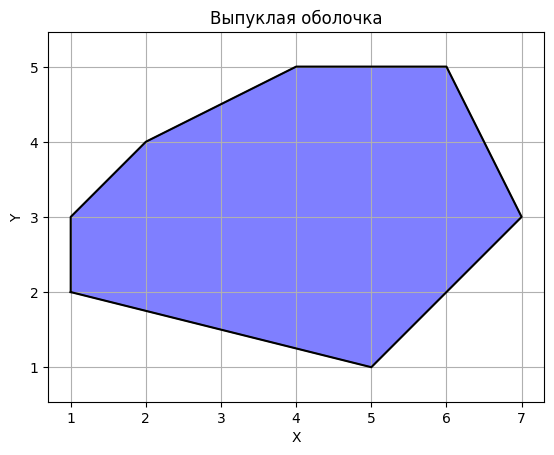

In [39]:
from shapely.geometry import Polygon
import numpy as np
from scipy.spatial import ConvexHull

def create_convex_hull(coords):
    """
    Создает полигон (выпуклую оболочку) из списка координат.

    :param coords: Список координат в формате [[x1, y1], [x2, y2], ...]
    :return: Объект Polygon, представляющий выпуклую оболочку
    """
    if len(coords) < 3:
        raise ValueError("Для создания полигона необходимо как минимум 3 точки.")

    # Преобразуем список координат в массив NumPy 
    points = np.array(coords)

    # Находим выпуклую оболочку
    hull = ConvexHull(points)

    # Извлекаем координаты вершин выпуклой оболочки 
    hull_points = points[hull.vertices]

    # Создаем полигон
    polygon = Polygon(hull_points)
    return polygon

def plot_polygon(polygon):
    """
    Отображает полигон на графике.

    :param polygon: Объект Polygon """
    x, y = polygon.exterior.xy  # Получаем координаты внешней границы полигона
    plt.fill(x, y, alpha=0.5, fc='blue', ec='black')  # Заполняем полигон цветом
    plt.plot(x, y, color='black')  # Рисуем границу полигона
    plt.title("Выпуклая оболочка")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')  # Устанавливаем равные масштабы по осям
    plt.grid()
    plt.show()

# Пример использования
coords = [[1, 2], [4, 5], [2, 3], [3, 4], [1, 3], [2, 4], [6, 5], [7,3], [5,1], [3,2], [4,3], [4, 2], [5, 2]]
polygon = create_convex_hull(coords)
plot_polygon(polygon)


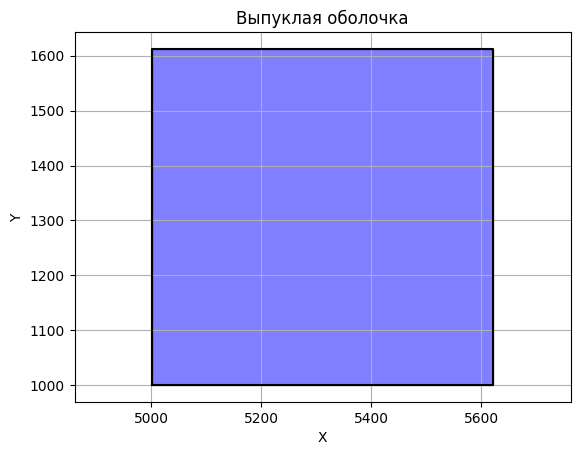

In [46]:
polygon_cube = create_convex_hull(cube)
plot_polygon(polygon_cube)

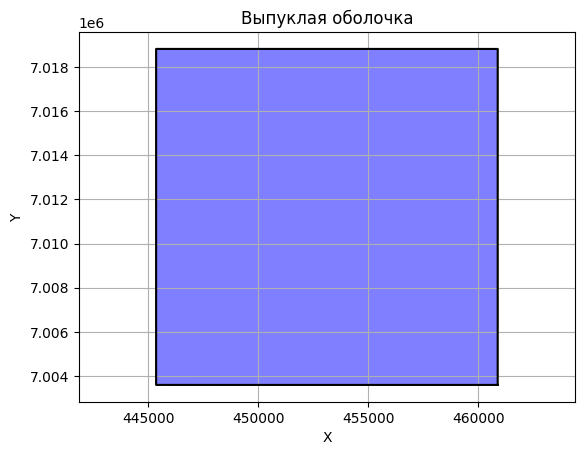

In [50]:
polygon_real_cube = create_convex_hull(real_cube)
plot_polygon(polygon_real_cube)

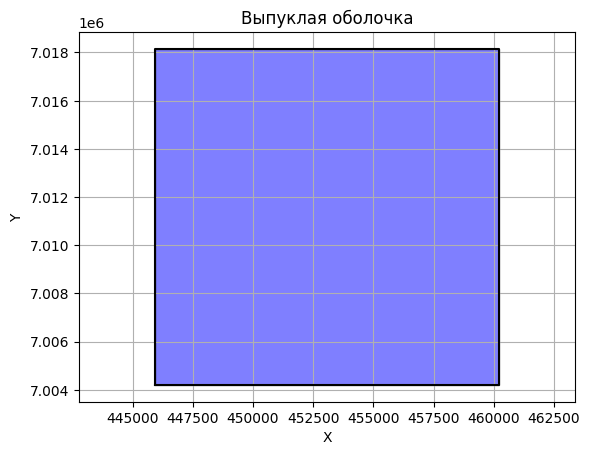

In [51]:
polygon_top_TWT = create_convex_hull(Top_TWT)
plot_polygon(polygon_top_TWT)

In [55]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def plot_polygons(polygon_1, polygon_2):
    """
    Отображает два полигона на графике.

    :param polygon_1: Объект Polygon 1 
    :param polygon_2: Объект Polygon 2
    """
    # Получаем координаты внешних границ полигонов
    x1, y1 = polygon_1.exterior.xy 
    x2, y2 = polygon_2.exterior.xy
    
    # Создаем график
    plt.figure(figsize=(8, 8))
 # Заполняем и рисуем первый полигон 
    plt.fill(x1, y1, alpha=0.5, fc='blue', ec='black', label='Полигон 1')
    plt.plot(x1, y1, color='black')
    
    # Заполняем и рисуем второй полигон 
    plt.fill(x2, y2, alpha=0.5, fc='red', ec='black', label='Полигон 2')
    plt.plot(x2, y2, color='black')
    
    # Настраиваем график
    plt.title("Отображение двух полигонов")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')  # Устанавливаем равные масштабы по осям 
    plt.grid()
    plt.legend()
    plt.show()

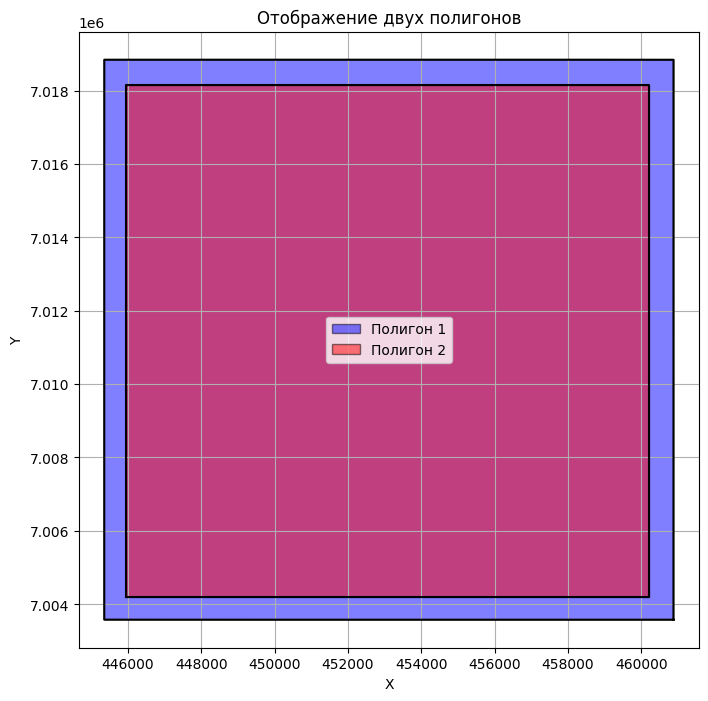

In [58]:
plot_polygons(polygon_real_cube, polygon_top_TWT)